# Analyze orientation detection task during structure learning

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg

from mindstorm import statplot
from tesser import tasks

bids_dir = os.environ['TESSER_BIDS']
fig_dir = os.path.join(os.environ['TESSER_FIGURES'], 'plots')
os.makedirs(fig_dir, exist_ok=True)

In [2]:
raw = tasks.load_struct(bids_dir)
data = tasks.exclude_struct_switched(raw)
data.head(5)

,onset,duration,trial_type,block,community,object,object_type,orientation,response,response_time,run,subject,part
0,0.0,1.5,structured,1,2,10,boundary,canonical,canonical,1.427,1,100,1
1,1.5,1.5,structured,1,2,5,central,canonical,canonical,0.759,1,100,1
2,3.0,1.5,structured,1,2,4,boundary,canonical,canonical,0.866,1,100,1
3,4.5,1.5,structured,1,1,3,boundary,canonical,canonical,0.713,1,100,1
4,6.0,1.5,structured,1,1,1,central,canonical,canonical,0.654,1,100,1


In [3]:
(data.query('part == 1')
    .groupby(['subject', 'object'])['onset']
    .count()
    .agg(['mean', 'std', 'min', 'max'])
)

mean     75.000000
std      18.261771
min      28.000000
max     135.000000
Name: onset, dtype: float64

In [4]:
(data.query('part == 1')
    .groupby(['subject', 'community'])['onset']
    .count()
    .agg(['mean', 'std', 'min', 'max'])
)

mean    525.000000
std     118.265649
min     238.000000
max     831.000000
Name: onset, dtype: float64

## Part 1 presentation counts

In [5]:
(data.query('part == 1')
    .groupby(['subject', 'object'])['onset']
    .count()
    .mean()
)

75.0

In [6]:
(data.query('part == 1')
    .groupby(['subject', 'object'])['onset']
    .count()
    .groupby(['subject'])
    .std()
    .agg(['mean', 'sem'])
)

mean    17.386771
sem      1.147660
Name: onset, dtype: float64

In [7]:
(data.query('part == 1')
    .groupby(['subject', 'community'])['onset']
    .count()
    .mean()
)

525.0

In [8]:
(data.query('part == 1')
    .groupby(['subject', 'community'])['onset']
    .count()
    .groupby(['subject'])
    .std()
    .agg(['mean', 'sem'])
)

mean    129.937716
sem      10.418100
Name: onset, dtype: float64

## Part 2 presentation counts

In [9]:
(data.query('part == 2')
    .groupby(['subject', 'object'])['onset']
    .count()
    .mean()
)

42.0

In [10]:
(data.query('part == 2')
    .groupby(['subject', 'object'])['onset']
    .count()
    .groupby(['subject'])
    .std()
    .agg(['mean', 'sem'])
)

mean    9.319345
sem     0.578807
Name: onset, dtype: float64

In [11]:
(data.query('part == 2')
    .groupby(['subject', 'community'])['onset']
    .count()
    .mean()
)

294.0

In [12]:
(data.query('part == 2')
    .groupby(['subject', 'community'])['onset']
    .count()
    .groupby(['subject'])
    .std()
    .agg(['mean', 'sem'])
)

mean    65.404393
sem      5.541667
Name: onset, dtype: float64

## Test whether performance was above chance

In [13]:
overall = data.groupby(['subject', 'part', 'run']).apply(tasks.test_rotation_perf, 10000)
overall['nr'] = 1 - overall['rr']
overall.agg(['mean', 'sem', 'min', 'max'])

,rr,hr,far,zhr,zfar,dprime,p,nr
mean,0.982290,0.921124,0.010849,1.542934,-2.500581,4.043516,1.000000e-04,0.017710
sem,0.003711,0.004865,0.001550,0.025829,0.019787,0.033456,6.742634e-22,0.003711
min,0.000000,0.255814,0.000000,-0.656305,-2.909231,1.960466,1.000000e-04,0.000000
max,1.000000,1.000000,0.350000,2.411822,-0.385320,5.292497,1.000000e-04,1.000000


In [14]:
subj = data.groupby(['subject']).apply(tasks.rotation_perf).reset_index()
subj['nr'] = 1 - subj['rr']
subj.agg(['mean', 'sem', 'min', 'max'])

,subject,rr,hr,far,zhr,zfar,dprime,nr
mean,118.621622,0.986338,0.927532,0.012710,1.596464,-2.426409,4.022874,0.013662
sem,1.880176,0.003011,0.011667,0.003128,0.073957,0.065099,0.109776,0.003011
min,100.000000,0.923484,0.582353,0.000481,0.207917,-3.301140,2.043930,0.000814
max,138.000000,0.999186,0.994318,0.109885,2.531313,-1.227141,5.707123,0.076516


In [15]:
res = data.groupby(['subject', 'part', 'run']).apply(tasks.rotation_perf).reset_index()

## Part 1

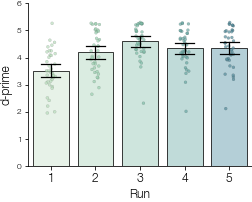

In [16]:
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    res.reset_index().query('part == 1'),
    x='run',
    y='dprime',
    dodge=True,
    legend=False,
    point_kind='strip',
    ax=ax,
)
ax.set(ylim=(0, 6), xlabel='Run', ylabel="d-prime")
fig.savefig(os.path.join(fig_dir, 'orientation_part1_dprime.pdf'));

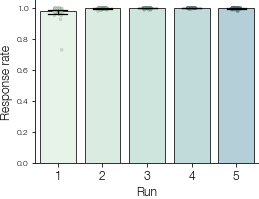

In [17]:
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    res.reset_index().query('part == 1'),
    x='run',
    y='rr',
    dodge=True,
    legend=False,
    point_kind='strip',
    ax=ax,
)
ax.set(xlabel='Run', ylabel="Response rate");

In [18]:
part1 = res.query('part == 1')
runs = part1.pivot(index='subject', columns='run', values='dprime')
pg.rm_anova(part1, dv='dprime', within='run', subject='subject')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,run,4,144,31.894377,5.053736e-19,0.469765,0.815958


In [19]:
# compare performance on adjacent runs
labels = [f'{r + 1} - {r}' for r in range(1, 5)]
tab_list = []
for r in range(1, 5):
    t = pg.ttest(runs[r + 1], runs[r], paired=True)
    diff = runs[r + 1] - runs[r]
    t['mean'] = diff.mean()
    t['sem'] = diff.sem()
    tab_list.append(t)
tab = pd.concat(tab_list, axis=0, ignore_index=True)
tab.index = labels
tab['pcor'] = pg.multicomp(tab['p-val'].to_numpy(), method='fdr_bh')[1]
tab

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,mean,sem,pcor
2 - 1,6.321663,36,two-sided,2.588415e-07,"[0.47, 0.91]",0.913540,6.076e+04,0.999713,0.688365,0.108890,0.000001
3 - 2,3.989797,36,two-sided,3.105943e-04,"[0.2, 0.61]",0.591043,88.912,0.937945,0.402626,0.100914,0.000621
4 - 3,-3.244320,36,two-sided,2.543796e-03,"[-0.43, -0.1]",0.411381,13.703,0.682675,-0.265563,0.081855,0.003392
5 - 4,0.247058,36,two-sided,8.062665e-01,"[-0.15, 0.19]",0.029677,0.182,0.053546,0.020866,0.084458,0.806266


## Part 2

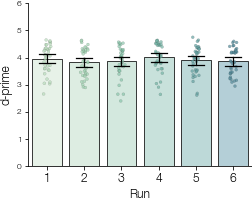

In [20]:
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    res.reset_index().query('part == 2'),
    x='run',
    y='dprime',
    dodge=True,
    legend=False,
    point_kind='strip',
    ax=ax,
)
ax.set(ylim=(0, 6), xlabel='Run', ylabel="d-prime")
fig.savefig(os.path.join(fig_dir, 'orientation_part2_dprime.pdf'));

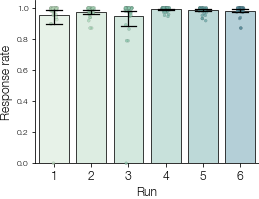

In [21]:
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    res.reset_index().query('part == 2'),
    x='run',
    y='rr',
    dodge=True,
    legend=False,
    point_kind='strip',
    ax=ax,
)
ax.set(xlabel='Run', ylabel="Response rate");

In [22]:
part2 = res.query('part == 2')
pg.rm_anova(part2, dv='dprime', within='run', subject='subject')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,run,5,170,1.794697,0.116411,0.050139,0.858767


In [23]:
part_means = res.groupby(['subject', 'part'])['dprime'].mean().reset_index()
tab = pd.pivot(data=part_means, index='subject', columns='part', values='dprime')
pg.ttest(tab[1], tab[2], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.59939,36,two-sided,0.000953,"[0.13, 0.48]",0.608457,32.623,0.949572


In [24]:
tab.agg(['mean', 'sem'])

part,1,2
mean,4.208407,3.903188
sem,0.095818,0.066487


In [25]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 7.28.0

pingouin  : 0.4.0
pandas    : 1.3.3
tesser    : 1.0.0
matplotlib: 3.4.3
mindstorm : 0.8.1

